In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich


from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [2]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch #conditional router

from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

from haystack.utils import Secret

In [3]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [4]:
rag_prompt_template = """
Answer the following query given the documents.
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =ElasticsearchEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "generator")


🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: ElasticsearchEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

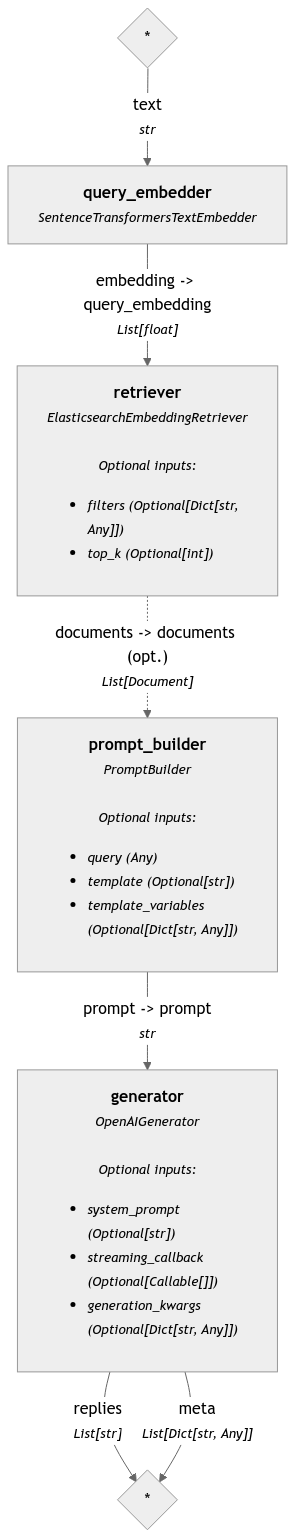

In [5]:
rag.show()

In [6]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
rich.print(result["llm"]["replies"][0])

KeyError: 'llm'

## Evaluate the Pipeline

For this tutorial, let's evaluate the pipeline with the following metrics since we don't have ground-truth labels:

- [ContextRelevace](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator): Uses an LLM to evaluate whether contexts are relevant to a question. It does not require ground truth labels.
- [Faithfulness](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator): Uses an LLM to evaluate whether a generated answer can be inferred from the provided contexts. Does not require ground truth labels.


For a full list of available metrics, check out the [Haystack Evaluators](https://docs.haystack.deepset.ai/docs/)

In [8]:
from haystack import Pipeline
from haystack.components.evaluators import ContextRelevanceEvaluator, FaithfulnessEvaluator

eval_pipeline = Pipeline()
eval_pipeline.add_component("context_relevance", ContextRelevanceEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar=True, raise_on_failure=False))
eval_pipeline.add_component("faithfulness", FaithfulnessEvaluator(api_key=Secret.from_token(OPENAI_API_TOKEN), progress_bar = True, raise_on_failure=False))

In [9]:
questions = ["Who is Tolkien?", "What did Tolkien write?", "Which is the 'The Hobbit' plot?", 
             "Tell me somthing about 'The Lord of the Rings", "Who is George Martin?", "What is 'A Song of Ice and Fire'?",
             "Where George Martin was born?", "What about Game of Thrones?"]

In [10]:
predicted_answers = []
retrieved_context = []

for question in questions: # loops over questions
  result = rag.run({"query_embedder":{"text":question}, "prompt_builder":{"query": question}}, include_outputs_from={"retriever"})
  predicted_answers.append(result["generator"]["replies"][0])
  retrieved_context.append(result["retriever"]["documents"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
predicted_answers

['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.',
 'Tolkien wrote novels, essays, and letters. His notable works include "The Hobbit" and his expansive creation of Middle-earth, which he developed over his lifetime.',
 "The plot of 'The Hobbit' follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwarves and the wizard Gandalf.",
 "'The Lord of the Rings' is a renowned literary work by J.R.R. Tolkien that was significantly influenced by a creative circle of friends, which fostered lasting relationships that enriched Tolkien’s life and career. Additionally, the story has been adapted into successful films directed by Peter Jackson, which helped introduce Tolkien’s world to new audiences and further solidified his status as a cultural icon.",
 'George Raymond Richard Martin, born o

In [12]:
retrieved_context

[[Document(id=4db796e36bf997d5b6962fb24e58b14064b0d001778edfe8caf9f8db3fdd041b, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 0.84023374, embedding: vector of size 384),
  Document(id=d97216d59bcf5d059a9ee86a9213080713f2ef1ad1a1c4be477c3d66bdbdec36, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': 'tolkien.txt', 'source_id': 'df36a6e19f29965789bd0aec4f23afb6cfe4436938474a5242b204a2fc777eb6', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 0.84023374, embedding: vector of size 384),
  Document(id=26f10b9b6260fd744f1a96e86080d0e204ab9b742c6a7c721e7aa79f86686898,

In [13]:
eval_pipeline_results = eval_pipeline.run(
    {
        "context_relevance": {"questions": questions, "contexts": retrieved_context},
        "faithfulness": {"questions": questions, "contexts": retrieved_context, "predicted_answers": predicted_answers},
    }
)

results = {
    "context_relevance": eval_pipeline_results['context_relevance'],
    "faithfulness": eval_pipeline_results['faithfulness'],
}

100%|██████████| 8/8 [00:24<00:00,  3.09s/it]


In [14]:
results

{'context_relevance': {'results': [{'relevant_statements': ['John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded...'],
    'score': 1},
   {'relevant_statements': ['The success of The Hobbit marked Tolkien’s emergence as a prominent author, and his creation of Middle-earth in literature.'],
    'score': 1},
   {'relevant_statements': ['The story follows Bilbo Baggins, a hobbit who embarks on a thrilling adventure with a group of dwar...'],
    'score': 1},
   {'relevant_statements': ['This creative circle played a significant role in the development of The Lord of the Rings.',
     'The cinematic adaptations of The Lord of the Rings and The Hobbit, directed by Peter Jackson, introduced a new audience to the world created by J.R.R. Tolkien.'],
    'score': 1},
   {'relevant_statements': ['George Raymond Richard Martin, born on September 20, 1948, in Bayonne, New Jersey, is celebrated as...'],
    'score': 1},
   {'relevant_statements': [

In [15]:
from haystack.evaluation import EvaluationRunResult

inputs = {
    'questions': questions,
    'contexts': retrieved_context,
    'predicted_answers': predicted_answers
}
run_name="rag_eval"
eval_results = EvaluationRunResult(run_name=run_name, inputs=inputs, results=results)
eval_results.score_report()

,metrics,score
0,context_relevance,1.000000
1,faithfulness,0.958333


In [16]:
eval_results.to_pandas()

,questions,contexts,predicted_answers,context_relevance,faithfulness
0,Who is Tolkien?,[Document(id=4db796e36bf997d5b6962fb24e58b1406...,"John Ronald Reuel Tolkien, born on January 3, ...",1,1.000000
1,What did Tolkien write?,[Document(id=cab8dca864050a6088d187555505f8700...,"Tolkien wrote novels, essays, and letters. His...",1,1.000000
2,Which is the 'The Hobbit' plot?,[Document(id=2b4c03360d8371d363ec2c2504cdfc31d...,The plot of 'The Hobbit' follows Bilbo Baggins...,1,0.666667
3,Tell me somthing about 'The Lord of the Rings,[Document(id=411302392105e05f49fca41767751c25c...,'The Lord of the Rings' is a renowned literary...,1,1.000000
4,Who is George Martin?,[Document(id=328c7141b08a6f76756fd12a73bd92b12...,"George Raymond Richard Martin, born on Septemb...",1,1.000000
5,What is 'A Song of Ice and Fire'?,[Document(id=aea31a8d999915ac87bbc692d74765714...,'A Song of Ice and Fire' is a series of epic f...,1,1.000000
6,Where George Martin was born?,[Document(id=328c7141b08a6f76756fd12a73bd92b12...,"George Martin was born in Bayonne, New Jersey.",1,1.000000
7,What about Game of Thrones?,[Document(id=1d3750482298bb06856609e344543f5d3...,Game of Thrones is an adaptation of George R.R...,1,1.000000
